In [49]:
import pandas as pd
import numpy as np
import implicit
import scipy.sparse as sparse
from scipy.sparse import lil_matrix
from sklearn.model_selection import train_test_split
import random
recipes = pd.read_csv("./RAW_recipes.csv")
users = pd.read_csv("./PP_users.csv")
interactions = pd.read_csv("./RAW_interactions.csv")
np.random.seed(1234)

In [50]:
interactions = interactions.sample(frac=1, random_state=42).reset_index(drop=True)

train, temp = train_test_split(interactions, test_size=0.4, random_state=42)
val, test = train_test_split(temp, test_size=0.5, random_state=42)

In [51]:
recipe_activity = test["recipe_id"].value_counts()
most_popular= recipe_activity.head(10).index.tolist()
random_recipes = recipe_activity.sample(10).index.tolist()
print("most popular:", most_popular)
print("random:", random_recipes)

most popular: [2886, 27208, 89204, 39087, 67256, 32204, 54257, 22782, 69173, 68955]
random: [322614, 81675, 454924, 11744, 137359, 54264, 273013, 29391, 100367, 378502]


In [52]:
recipes_set = set()
user_recipes = {}

# Populate user_recipes and recipes_set from training interactions
for row in train.itertuples():
    user = row[1]
    recipe = row[2]
    rating = int(row[4])
    recipes_set.add(recipe)
    if user not in user_recipes:
        user_recipes[user] = []
    if rating > 3:
        user_recipes[user].append(recipe)


recipes_set = np.sort(list(recipes_set))

# Sort recipes and create a mapping of recipe IDs
recipes_ids = {i: recipe for i, recipe in enumerate(recipes_set)}

# Populate user_recipes_test from validation interactions
user_recipes_test = {}
for row in test.itertuples():
    user = row[1]
    recipe = row[2]
    rating = int(row[4])
    if user not in user_recipes_test:
        user_recipes_test[user] = []
    user_recipes_test[user].append(recipe)


# Create a mapping of user IDs
user_ids = {user: i for i, user in enumerate(user_recipes.keys())}

from scipy.sparse import lil_matrix

# Initialize sparse matrix using lil_matrix
sparse_matrix = lil_matrix((len(user_recipes), len(recipes_set)), dtype=int)

# Populate sparse matrix
for i, items in enumerate(user_recipes.values()):
    sparse_matrix[i] = np.isin(recipes_set, items, assume_unique=True).astype(int)

matrix = sparse.csr_matrix(sparse_matrix.T)
user_recipe_matrix = matrix.T.tocsr()



In [53]:
def evaluate_model_random_popular(recommendations, k):
    mean_map = 0.0
    mean_ndcg = 0.0
    mean_recall = 0.0
    users_tested = 0
    recommendations = recommendations[:k]
    for u in user_recipes_test.keys():
        if user_ids.get(u) != None:
            users_tested += 1
            rel_vector = [
                np.isin(user_recipes_test[u], recommendations, assume_unique=True).astype(int)
            ]
            mean_map += mean_average_precision(rel_vector)
            mean_ndcg += ndcg_at_k(rel_vector, k)
            if len(user_recipes_test[u]) > 0:
                mean_recall += np.sum(rel_vector[0]) / len(user_recipes_test[u])

    mean_map /= users_tested
    mean_ndcg /= users_tested
    mean_recall /= users_tested

    return mean_map, mean_ndcg, mean_recall

# Definicion de métricas (No editar)
# Obtenido de https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

In [54]:
random_map, random_ndcg, random_recall = evaluate_model_random_popular(random_recipes,10)
most_popular_map, most_popular_ndcg, most_popular_recall = evaluate_model_random_popular(most_popular,10)
print(f"Random: MAP@10: {random_map}, NDCG@10: {random_ndcg}, Recall@10: {random_recall}")
print(f"Most Popular: MAP@10: {most_popular_map}, NDCG@10: {most_popular_ndcg}, Recall@10: {most_popular_recall}")

Random: MAP@10: 0.0001356377818180618, NDCG@10: 0.0006131959774343881, Recall@10: 9.177331224385275e-05
Most Popular: MAP@10: 0.028072120071269385, NDCG@10: 0.052980132450331126, Recall@10: 0.019919186147775263


In [68]:
def evaluate_model(model, n):
    mean_map = 0.0
    mean_ndcg = 0.0
    mean_recall = 0.0
    users_tested = 0
    total_diff_most_popular = 0
    total_diff_our_model = 0
    total_diff_random = 0
    most_popular_nutrients = recipes.loc[recipes["id"]== most_popular[0], "nutrition"].values[0].replace("[","").replace("]","").split(",")
    
    for u in user_recipes_test.keys():
        if user_ids.get(u) != None:
            users_tested += 1
            gender = random.choice(["male", "female"])
            age = random.randint(18, 70)
            weight = random.randint(50, 100)
            height = random.randint(150, 200)
            physical_activity = random.choice(
                [
                    "sedentary",
                    "lightly active",
                    "moderately active",
                    "very active",
                    "extra active",
                ]
            )

            needed_nutrition = get_nutritional_values(
                gender, age, weight, height, physical_activity
            )

            rec = model.recommend(user_ids[u], user_recipe_matrix[user_ids[u]], n * 2)[
                0
            ]
            vectorized_function = np.vectorize(get_recipe_id)
            rec = vectorized_function(rec)

            sorted_recommendations = []
            for i in rec:
                recipe_nutrition = get_recipe_nutrition(i)
                recipe_nutrition_diff = get_nutrition_diff(
                    needed_nutrition, recipe_nutrition
                )
                sorted_recommendations.append((i, recipe_nutrition_diff))

            sorted_recommendations = sorted(sorted_recommendations, key=lambda x: x[1])
            sorted_recommendations = [i[0] for i in sorted_recommendations]

            rec = sorted_recommendations[:n]

            rel_vector = [
                np.isin(user_recipes_test[u], rec, assume_unique=True).astype(int)
            ]
    

            top_recipe_nutrients = recipes.loc[recipes["id"]== rec[0], "nutrition"].values[0].replace("[","").replace("]","").split(",")

            random_recipe = random.choice(random_recipes)
            random_nutrients = get_recipe_nutrition(random_recipe)

            total_diff_random += get_nutrition_diff(needed_nutrition, random_nutrients)
            total_diff_our_model += get_nutrition_diff(needed_nutrition, top_recipe_nutrients)
        
            total_diff_most_popular += get_nutrition_diff(needed_nutrition, most_popular_nutrients)
            
            mean_map += mean_average_precision(rel_vector)
            mean_ndcg += ndcg_at_k(rel_vector, n)
            if len(user_recipes_test[u]) > 0:
                mean_recall += np.sum(rel_vector[0]) / len(user_recipes_test[u])
            

    mean_map /= users_tested
    mean_ndcg /= users_tested
    mean_recall /= users_tested
    total_diff_our_model /= users_tested
    total_diff_most_popular /= users_tested
    total_diff_random /= users_tested

    print("Average difference on needed nutrition vs nutrition of reccomended recipe: ", str(total_diff_our_model*100)[:5]+"%")
    print("Average difference on needed nutrition vs nutrition of most popular recipe: ", str(total_diff_most_popular*100)[:5]+"%")
    print("Average difference on needed nutrition vs nutrition of random recipe: ", str(total_diff_random*100)[:5]+"%")
    print("MAP", mean_map)
    print("NDCG", mean_ndcg)
    print("RECALL", mean_recall)
    return mean_map, mean_ndcg, mean_recall

In [55]:
def get_recipe_id(num):
    return recipes_ids[num]


def get_nutritional_values(gender, age, weight, height, physical_activity):
    # Basal Metabolic Rate (BMR) calculation
    if gender.lower() == "male":
        bmr = 88.362 + (13.397 * weight) + (4.799 * height) - (5.677 * age)
    else:
        bmr = 447.593 + (9.247 * weight) + (3.098 * height) - (4.330 * age)

    # Physical Activity Factor (PAF)
    activity_levels = {
        "sedentary": 1.2,
        "lightly active": 1.375,
        "moderately active": 1.55,
        "very active": 1.725,
        "extra active": 1.9,
    }
    paf = activity_levels.get(physical_activity.lower(), 1.2)

    # Daily Caloric Needs
    daily_caloric_needs = bmr * paf

    nutritional_values = [
        daily_caloric_needs,  # Calories
        100,
        100,
        100,
        100,
        100,
        100,
    ]

    nutritional_values = list(map(lambda x: x / 3, nutritional_values))

    return nutritional_values


def get_recipe_nutrition(recipe):
    recipe_nutrition = recipes[recipes["id"] == recipe]["nutrition"].values[0]
    recipe_nutrition = recipe_nutrition.replace("[", "").replace("]", "").split(", ")
    recipe_nutrition = list(map(lambda x: float(x), recipe_nutrition))
    return recipe_nutrition

def get_nutrition_diff(needed_nutrition, recipe_nutrition):
    total_difference = 0
    for needed, recipe in zip(needed_nutrition, recipe_nutrition):
        total_difference += abs((float(needed) - float(recipe)) / float(needed))        
    return total_difference

In [67]:

users_tested = 0
    
for u in user_recipes_test.keys():
    if user_ids.get(u) != None:
        users_tested += 1
        gender = random.choice(["male", "female"])
        age = random.randint(18, 70)
        weight = random.randint(50, 100)
        height = random.randint(150, 200)
        physical_activity = random.choice(
            [
                "sedentary",
                "lightly active",
                "moderately active",
                "very active",
                "extra active",
            ]
        )

        needed_nutrition = get_nutritional_values(
            gender, age, weight, height, physical_activity
        )

        random_recipe = random.choice(random_recipes)
        random_nutrients = get_recipe_nutrition(random_recipe)

        total_diff_random += get_nutrition_diff(needed_nutrition, random_nutrients)

print(total_diff_random/users_tested)
        

5.464214470613575


In [57]:
model = implicit.als.AlternatingLeastSquares(factors=50, iterations=10)
model.fit(user_recipe_matrix)

  0%|          | 0/10 [00:00<?, ?it/s]

In [58]:
print(evaluate_model(model, 10))

Average difference on needed nutrition vs nutrition of reccomended recipe:  259.0%
Average difference on needed nutrition vs nutrition of most popular recipe:  510.1%
MAP 0.01748458369939333
NDCG 0.039857738533235224
RECALL 0.010838892912156567
(0.01748458369939333, 0.039857738533235224, 0.010838892912156567)


In [69]:
model = implicit.als.AlternatingLeastSquares(factors=10)
model.fit(user_recipe_matrix)
print(evaluate_model(model, 10))
model = implicit.bpr.BayesianPersonalizedRanking(factors=10)
model.fit(user_recipe_matrix)
print(evaluate_model(model, 10))

  0%|          | 0/15 [00:00<?, ?it/s]

Average difference on needed nutrition vs nutrition of reccomended recipe:  260.3%
Average difference on needed nutrition vs nutrition of most popular recipe:  510.2%
Average difference on needed nutrition vs nutrition of random recipe:  547.7%
MAP 0.019002771751835287
NDCG 0.042218543046357616
RECALL 0.012360227146588187
(0.019002771751835287, 0.042218543046357616, 0.012360227146588187)


  0%|          | 0/100 [00:00<?, ?it/s]

Average difference on needed nutrition vs nutrition of reccomended recipe:  284.0%
Average difference on needed nutrition vs nutrition of most popular recipe:  510.2%
Average difference on needed nutrition vs nutrition of random recipe:  547.4%
MAP 0.004469670960548531
NDCG 0.012171940152072602
RECALL 0.0025126085368340862
(0.004469670960548531, 0.012171940152072602, 0.0025126085368340862)


In [61]:
import time
models = ["ALS", "BPR"]
factors = [10, 25, 50, 100, 200]

resultados_matrix_factorization = {}

for model_name in models:
    for factor in factors:
        if model_name == "ALS":
            model = implicit.als.AlternatingLeastSquares(factors=factor)
        else:
            model = implicit.bpr.BayesianPersonalizedRanking(factors=factor)
        start = time.time()
        model.fit(user_recipe_matrix)
        training_time = time.time() - start
        map10, ndcg10, recall10 = evaluate_model(model, n=10)

        resultados_matrix_factorization[(model_name, factor)] = {
            "map": map10,
            "ndcg": ndcg10,
            "recall": recall10,
            "training time": training_time,
        }
for model_name in models:
    for factor in factors:
        print(
            "{model} {factor}: MAP: {map} NDCG: {ndcg} Recall: {recall}".format(
                model=model_name,
                factor=factor,
                **resultados_matrix_factorization[(model_name, factor)],
            )
        )


  0%|          | 0/15 [00:00<?, ?it/s]

Average difference on needed nutrition vs nutrition of reccomended recipe:  260.4%
Average difference on needed nutrition vs nutrition of most popular recipe:  510.2%
MAP 0.01868245775754503
NDCG 0.04191194505764042
RECALL 0.012181065929842624


  0%|          | 0/15 [00:00<?, ?it/s]

Average difference on needed nutrition vs nutrition of reccomended recipe:  259.1%
Average difference on needed nutrition vs nutrition of most popular recipe:  510.2%
MAP 0.01819852614011523
NDCG 0.04111479028697572
RECALL 0.011580763895746722


  0%|          | 0/15 [00:00<?, ?it/s]

Average difference on needed nutrition vs nutrition of reccomended recipe:  259.3%
Average difference on needed nutrition vs nutrition of most popular recipe:  510.2%
MAP 0.017226149684958683
NDCG 0.03893794456708364
RECALL 0.010817559996617447


  0%|          | 0/15 [00:00<?, ?it/s]

Average difference on needed nutrition vs nutrition of reccomended recipe:  263.1%
Average difference on needed nutrition vs nutrition of most popular recipe:  510.1%
MAP 0.014610116021941257
NDCG 0.03525876870247731
RECALL 0.009487493264165241


  0%|          | 0/15 [00:00<?, ?it/s]

Average difference on needed nutrition vs nutrition of reccomended recipe:  269.1%
Average difference on needed nutrition vs nutrition of most popular recipe:  510.2%
MAP 0.011025656516726233
NDCG 0.026888643610497916
RECALL 0.006801579349221368


  0%|          | 0/100 [00:00<?, ?it/s]

Average difference on needed nutrition vs nutrition of reccomended recipe:  271.8%
Average difference on needed nutrition vs nutrition of most popular recipe:  510.3%
MAP 0.004418541384140167
NDCG 0.012110620554329163
RECALL 0.0025343567956448093


  0%|          | 0/100 [00:00<?, ?it/s]

Average difference on needed nutrition vs nutrition of reccomended recipe:  282.0%
Average difference on needed nutrition vs nutrition of most popular recipe:  510.1%
MAP 0.003911069824174232
NDCG 0.012662496934020114
RECALL 0.002023226945008873


  0%|          | 0/100 [00:00<?, ?it/s]

Average difference on needed nutrition vs nutrition of reccomended recipe:  275.7%
Average difference on needed nutrition vs nutrition of most popular recipe:  510.2%
MAP 0.003879113554934931
NDCG 0.012693156732891833
RECALL 0.001999567499207481


  0%|          | 0/100 [00:00<?, ?it/s]

Average difference on needed nutrition vs nutrition of reccomended recipe:  309.9%
Average difference on needed nutrition vs nutrition of most popular recipe:  510.2%
MAP 0.0038026457013586572
NDCG 0.013183713514839343
RECALL 0.0020510364375782384


  0%|          | 0/100 [00:00<?, ?it/s]

Average difference on needed nutrition vs nutrition of reccomended recipe:  317.0%
Average difference on needed nutrition vs nutrition of most popular recipe:  510.2%
MAP 0.003435904979020708
NDCG 0.012386558744174637
RECALL 0.0019740592489336595
ALS 10: MAP: 0.01868245775754503 NDCG: 0.04191194505764042 Recall: 0.012181065929842624
ALS 25: MAP: 0.01819852614011523 NDCG: 0.04111479028697572 Recall: 0.011580763895746722
ALS 50: MAP: 0.017226149684958683 NDCG: 0.03893794456708364 Recall: 0.010817559996617447
ALS 100: MAP: 0.014610116021941257 NDCG: 0.03525876870247731 Recall: 0.009487493264165241
ALS 200: MAP: 0.011025656516726233 NDCG: 0.026888643610497916 Recall: 0.006801579349221368
BPR 10: MAP: 0.004418541384140167 NDCG: 0.012110620554329163 Recall: 0.0025343567956448093
BPR 25: MAP: 0.003911069824174232 NDCG: 0.012662496934020114 Recall: 0.002023226945008873
BPR 50: MAP: 0.003879113554934931 NDCG: 0.012693156732891833 Recall: 0.001999567499207481
BPR 100: MAP: 0.0038026457013586572 

In [47]:
print(resultados_matrix_factorization)

{('ALS', 10): {'map': 0.0005715560264309811, 'ndcg': 0.0010873504893077202, 'recall': 0.00023879069569110716, 'training time': 0.16875791549682617}, ('ALS', 25): {'map': 0.001812250815512867, 'ndcg': 0.001812250815512867, 'recall': 0.0016310257339615802, 'training time': 0.20927762985229492}, ('ALS', 50): {'map': 0.0007007369819983086, 'ndcg': 0.0014498006524102935, 'recall': 0.0004487478209841385, 'training time': 0.30834054946899414}, ('ALS', 100): {'map': 0.0032016431074060646, 'ndcg': 0.003624501631025734, 'recall': 0.002929805485079135, 'training time': 0.6015992164611816}, ('ALS', 200): {'map': 0.003050622206113326, 'ndcg': 0.004349401957230881, 'recall': 0.002491570287873296, 'training time': 1.4644415378570557}, ('BPR', 10): {'map': 0.0014800048326688417, 'ndcg': 0.0021747009786154403, 'recall': 0.0013138818412468285, 'training time': 0.3210620880126953}, ('BPR', 25): {'map': 0.0004893077201884741, 'ndcg': 0.0010873504893077202, 'recall': 0.00030204180258547786, 'training time'

In [40]:
def plot_bar_chart(data):
    als_data = [
        resultados_matrix_factorization[(model, factor)][data] for model, factor in resultados_matrix_factorization if model == "ALS"
    ]
    bpr_data = [
        resultados_matrix_factorization[(model, factor)][data] for model, factor in resultados_matrix_factorization if model == "BPR"
    ]

    bar_width = 0.35

    # Set the positions of the bars
    index = range(len(factors))
    index_1 = index
    index_2 = [i + bar_width for i in index]

    # Create bars for the first company
    plt.bar(index_1, als_data, width=bar_width, color="blue", label="ALS")

    # Create bars for the second company
    plt.bar(index_2, bpr_data, width=bar_width, color="red", label="BPR")
    if data == 'training time':
      data = data.upper()
    else:
      data = data.upper() + "@10"
    plt.xlabel("Factors")
    plt.ylabel(data)
    plt.title(f"{data} by Factors")
    plt.xticks([i + bar_width / 2 for i in index], factors)
    plt.legend()
    plt.show()


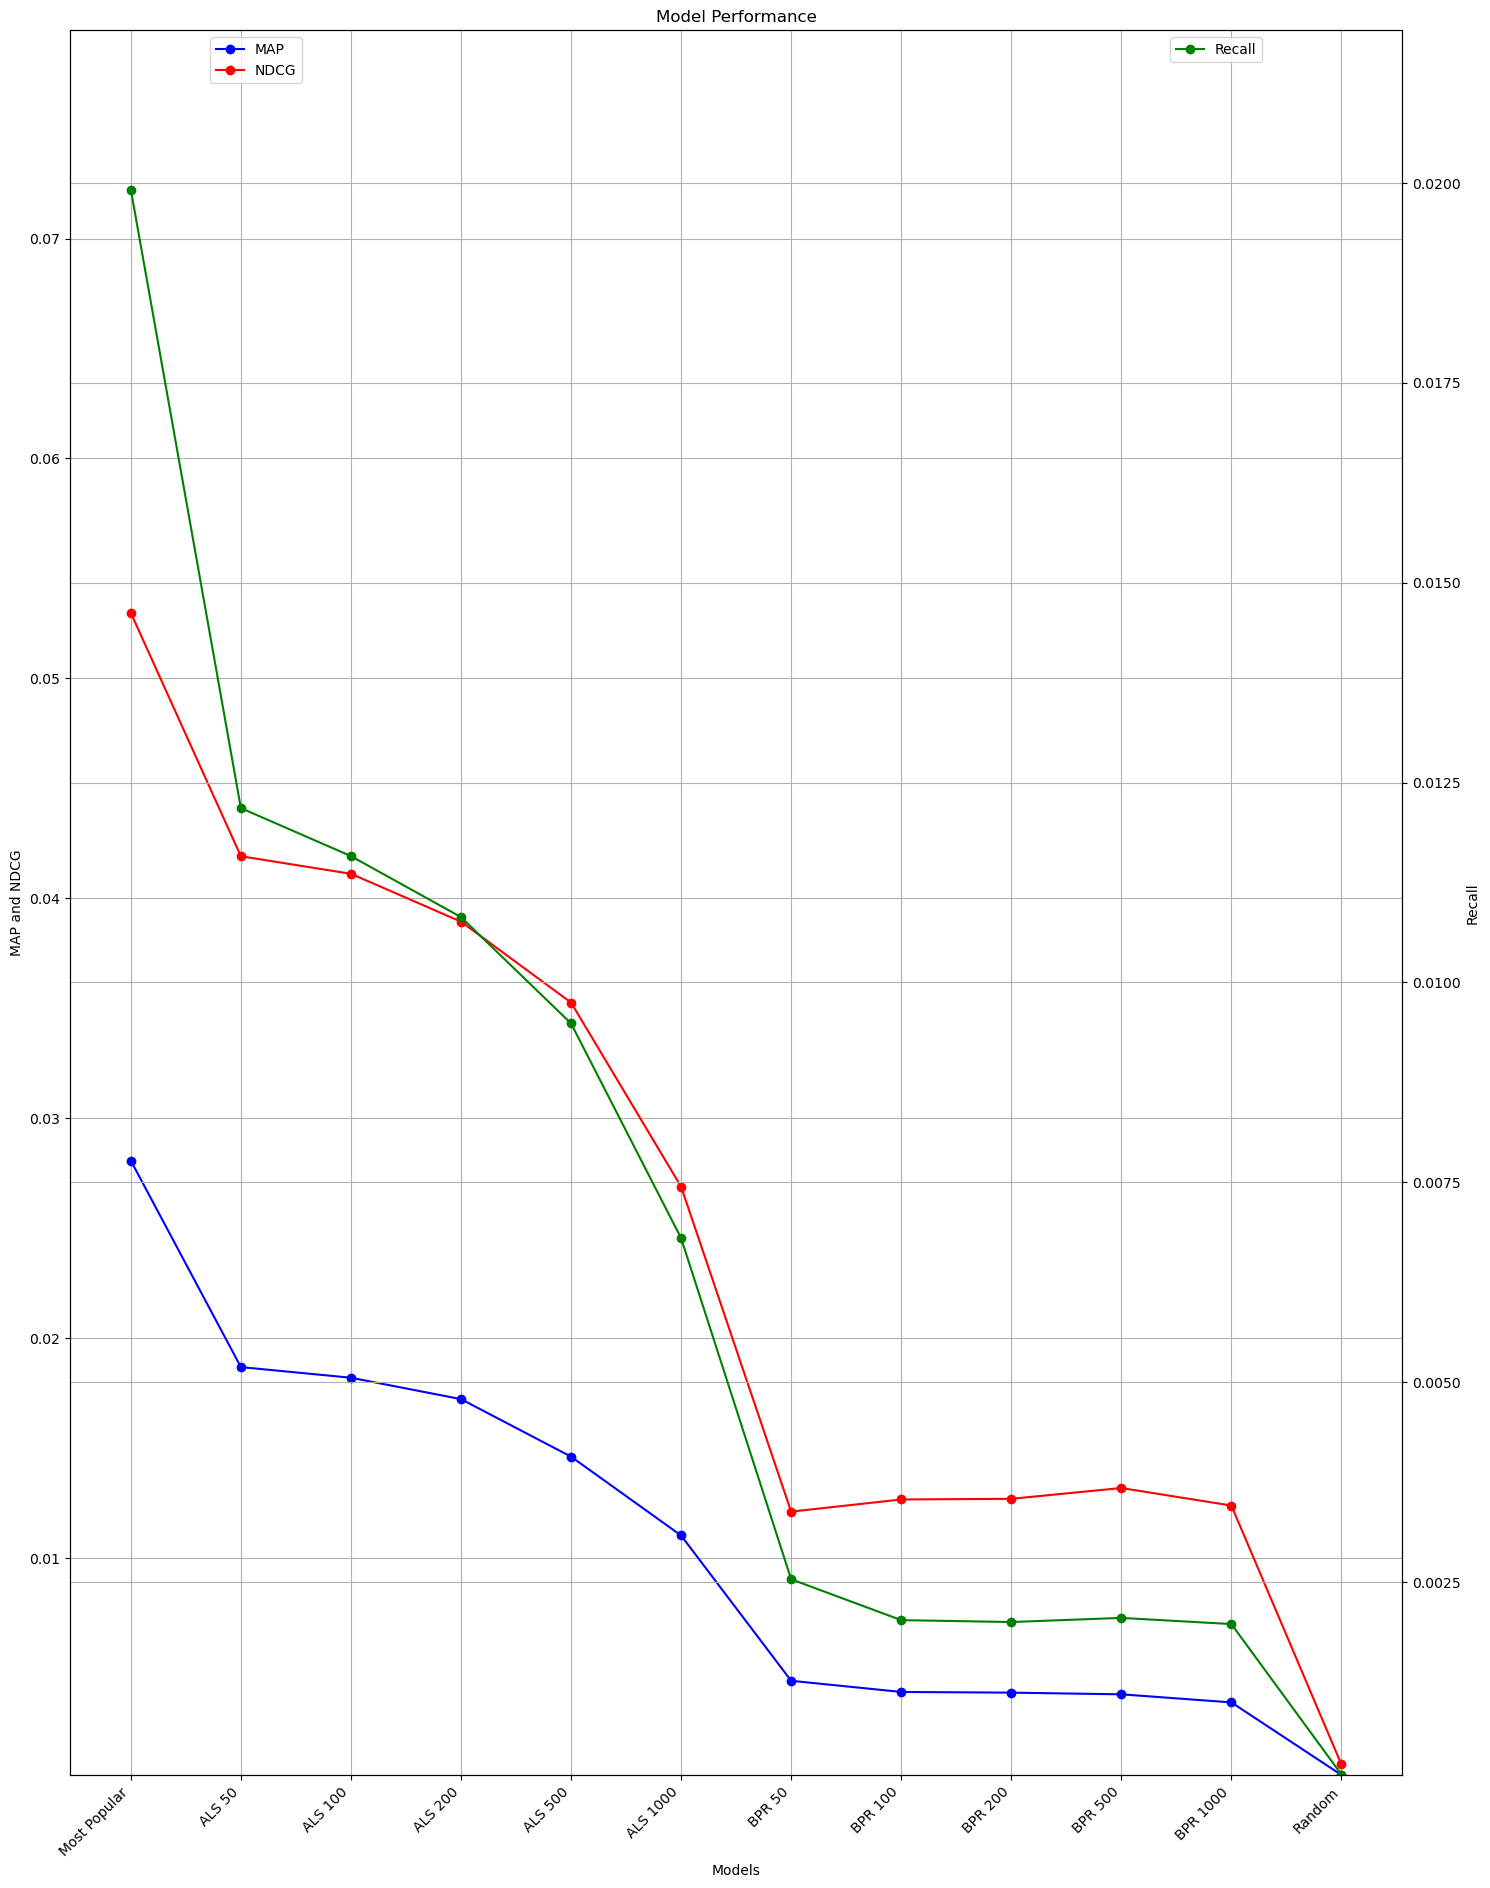

In [70]:
import matplotlib.pyplot as plt

# Data
labels = ['Most Popular', 'ALS 10', 'ALS 25', 'ALS 50', 'ALS 100', 'ALS 200', 
          'BPR 10', 'BPR 25', 'BPR 50', 'BPR 100', 'BPR 200',
          'Random']
models = ["ALS", "BPR"]
factors = [10, 25, 50, 100, 200]


map_values = []
ndcg_values = []
recall_values = []

map_values.append(most_popular_map)
ndcg_values.append(most_popular_ndcg)
recall_values.append(most_popular_recall)
for model in models:
    for factor in factors:
        results = resultados_matrix_factorization[(model, factor)]
        map_values.append(results["map"])
        ndcg_values.append(results["ndcg"])
        recall_values.append(results["recall"])

map_values.append(random_map)
ndcg_values.append(random_ndcg)
recall_values.append(random_recall)



# Plotting
fig, ax1 = plt.subplots(figsize=(15, 22))  # Increase width for horizontal stretch

ax1.set_xlabel('Models')
ax1.set_ylabel('MAP and NDCG')
ax1.plot(labels, map_values, 'b-', marker='o', label='MAP')
ax1.plot(labels, ndcg_values, 'r-', marker='o', label='NDCG')
ax1.tick_params(axis='y')
ax1.grid(True)  # Add grid lines for better readability

# Adding padding to y-axis limits for ax1
ax1.set_ylim([min(min(map_values), min(ndcg_values)) * 0.9, max(max(map_values), max(ndcg_values)) * 1.5])

ax1.legend(loc='upper left', bbox_to_anchor=(0.1, 1))

ax2 = ax1.twinx()
ax2.set_ylabel('Recall')
ax2.plot(labels, recall_values, 'g-', marker='o', label='Recall')
ax2.tick_params(axis='y')
ax2.grid(True)  # Add grid lines for better readability

# Adding padding to y-axis limits for ax2
ax2.set_ylim([min(recall_values) * 0.9, max(recall_values) * 1.1])

ax2.legend(loc='upper right', bbox_to_anchor=(0.9, 1))

fig.tight_layout()
fig.autofmt_xdate(rotation=45)

plt.title('Model Performance')
plt.savefig('model_performance.png', dpi=1000)  # Save with higher DPI for better quality

plt.show()
